# 프로젝트 : 고양이 수염 스티커 만들기(feat. 국민MC)

## 사진 준비하기

### 이미지 불러오기

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import os

image_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/mcyoo.png'
img_bgr = cv2.imread(image_path)  # OpenCV로 이미지 읽기
img_bgr = cv2.resize(img_bgr, (480, 640))  # 이미지 resize(두번째 파라미터에 사이즈를 입력해준다.)
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # plt.imshow 이전에 RGB 이미지로 변경!
plt.imshow(img_rgb)
plt.show()

## 얼굴 검출 및 랜드마크 검출하기

- Object detection 기술을 이용해서 얼굴의 위치를 찾는다.
- dilb의 fact detector는 HOG feature를 사용해서 SVM sliding window로 얼굴을 찾는다.

In [ ]:
# dlib를 활용해 hog detector 선언하기

import dlib
detector_hog = dlib.get_frontal_face_detector()

### 이미지 피라미드
- detector_hog의 두 번째 파라미터는 이미지 피라미드의 수
- 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다.
- 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능

In [ ]:
# detector를 이용해 얼굴의 bounding box 추출하기

# cvtColor()
# dlib는 rgb로 이미지를 입벽받기 때문에 bgr 2 rgb 필요
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # dlib는 rgb로 이미지를 입력 받음, cvtColor 이용 opencv bgr 이미지를 rgb로 전환 

# dlib.get_frontal_face_detector()
# 두번째 파라미터는 이미지 피라미드 수
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

### 검출한 얼굴 출력

In [ ]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

In [ ]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Face lnadmark

- 스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요
- 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 함
- face landmark는 detection의 결과물인 bounding box로 잘라낸 얼굴이미지를 이용함

### object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식을 다룹니다.

### dlib landmark localization

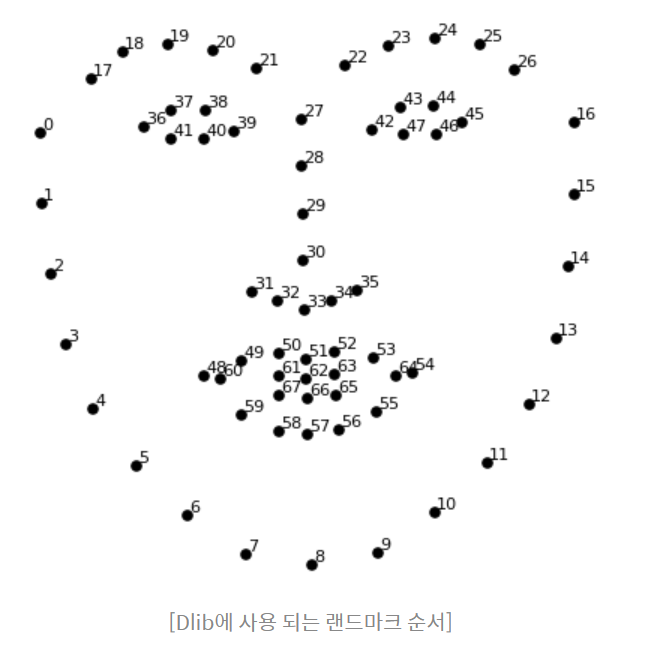

In [ ]:
# landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [ ]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

In [ ]:
# 이미지에 landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용하기

### 스티커 위치 및 크기 계산

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # nose center index :30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x,y) : (%d, %d)'%(x,y))  # 스티커의 위치 (x,y)
    print('(w,h) : (%d, %d)'%(w,h))  # 스티커의 크기 (w,h)

### 스티커 resize & 좌표 조정

In [ ]:
# 스티커 이미지를 읽어와 윗 단계에서 계산한 크기로 resize
import os
sticker_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

In [ ]:
# 이미지의 시작점(top-left) x, y 좌표 조정
refined_x = x - w // 2 #left
refined_y = y - h // 2 # top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [ ]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

In [ ]:
# sticker area
# 원본 이미지에서 스티커를 적용할 위치를 crop한 이미지

In [ ]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

In [ ]:
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 새로운 시도

### 다른 각도

In [ ]:
import os
image_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/mcyoo2.png'
img_bgr = cv2.imread(image_path)  # OpenCV로 이미지 읽기
img_bgr = cv2.resize(img_bgr, (660, 371))  # 660 X 371 사이즈로 resize 
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

In [ ]:
# plt.imshow 이전에 RGB 이미지로 변경!

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [ ]:
import dlib
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # dlib는 rgb로 이미지를 입력 받음, cvtColor 이용 opencv bgr 이미지를 rgb로 전환 

# dlib.get_frontal_face_detector()
# 두번째 파라미터는 이미지 피라미드 수
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

In [ ]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
# landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [ ]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

In [ ]:
# 이미지에 landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33]) # nose center index :30
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x,y) : (%d, %d)'%(x,y))  # 스티커의 위치 (x,y)
    print('(w,h) : (%d, %d)'%(w,h))  # 스티커의 크기 (w,h)

In [ ]:
# 스티커 이미지를 읽어와 윗 단계에서 계산한 크기로 resize
import os
sticker_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

In [ ]:
# 이미지의 시작점(top-left) x, y 좌표 조정
refined_x = x - w // 2 #left
refined_y = y - h // 2 # top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [ ]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 45도 사진

__Load image__

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
image_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/mcyoo_45.png'
img_bgr = cv2.imread(image_path)  # OpenCV로 이미지 읽기
img_bgr = cv2.resize(img_bgr, (800, 480))  # 660 X 371 사이즈로 resize 
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

__Face detection__

In [ ]:
# dlib를 활용해 hog detector 선언하기
import dlib
detector_hog = dlib.get_frontal_face_detector()  # detector 선언

# detector를 이용해 얼굴의 bounding box 추출하기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # (image, num of img pyramid)
dlib_rects = detector_hog(img_rgb, 1) # dlib는 rgb로 이미지를 입력 받음, cvtColor 이용 opencv bgr 이미지를 rgb로 전환

# 찾은 얼굴을 화면에 출력하기

print(dlib_rects) # 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

__Face landmark__

In [ ]:
import os
model_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

# 
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

__스티커 적용하기__

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # nose center index :30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

print('-----------------')

# 스티커 이미지를 읽어와 윗 단계에서 계산한 크기로 resize
import os
sticker_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

print('-----------------')

# 이미지의 시작점(top-left) x, y 좌표 조정
refined_x = x - w // 2 #left
refined_y = y - h // 2 # top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [ ]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 어두운 사진

__이미지 불러오기__

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
image_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/mcyoo_dark.png'
img_bgr = cv2.imread(image_path)  # OpenCV로 이미지 읽기
img_bgr = cv2.resize(img_bgr, (480, 640))  # 660 X 371 사이즈로 resize 
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

__Face detection__

In [ ]:
# dlib를 활용해 hog detector 선언하기
import dlib
detector_hog = dlib.get_frontal_face_detector()  # detector 선언

# detector를 이용해 얼굴의 bounding box 추출하기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # (image, num of img pyramid)
dlib_rects = detector_hog(img_rgb, 1) # dlib는 rgb로 이미지를 입력 받음, cvtColor 이용 opencv bgr 이미지를 rgb로 전환

# 찾은 얼굴을 화면에 출력하기

print(dlib_rects) # 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

__Face landmark__

In [ ]:
import os
model_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

# 
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

__스티커 적용하기__

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # nose center index :30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

print('-----------------')

# 스티커 이미지를 읽어와 윗 단계에서 계산한 크기로 resize
import os
sticker_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

print('-----------------')

# 이미지의 시작점(top-left) x, y 좌표 조정
refined_x = x - w // 2 #left
refined_y = y - h // 2 # top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [ ]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 마스크 쓴 사진

__이미지 불러오기__

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
image_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/mcyoo_mask.png'
img_bgr = cv2.imread(image_path)  # OpenCV로 이미지 읽기
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

__Face dection__

In [ ]:
# dlib를 활용해 hog detector 선언하기
import dlib
detector_hog = dlib.get_frontal_face_detector()  # detector 선언

# detector를 이용해 얼굴의 bounding box 추출하기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # (image, num of img pyramid)
dlib_rects = detector_hog(img_rgb, 1) # dlib는 rgb로 이미지를 입력 받음, cvtColor 이용 opencv bgr 이미지를 rgb로 전환

# 찾은 얼굴을 화면에 출력하기

print(dlib_rects) # 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 회고

In [ ]:
실력 부족인지 모르나 마스크를 쓴 사진은 box가 안생긴다.